### Set up the points and the graph

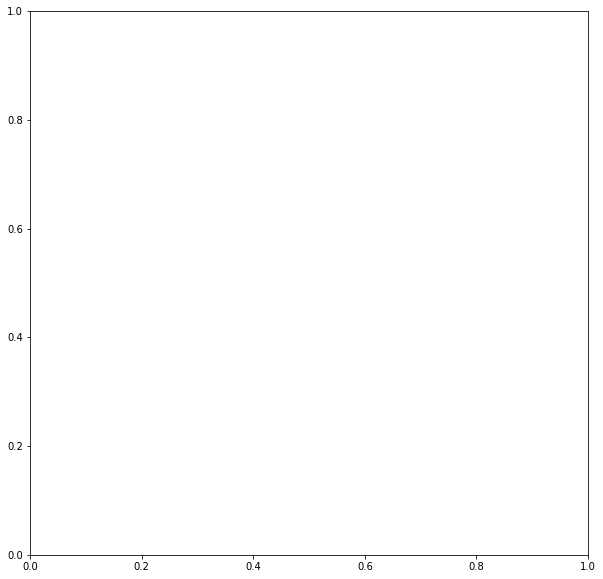

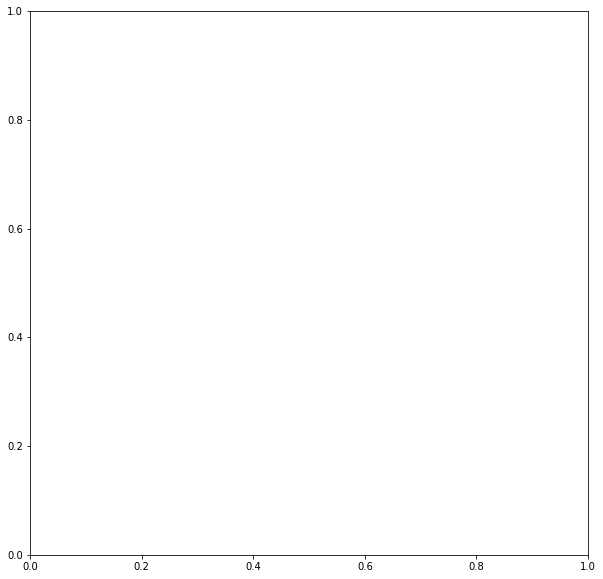

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.stats
import matplotlib.pyplot as plt
from research_module import *
from copy import copy, deepcopy
from point import Point
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly
from plot import *


fig, ax = plt.subplots(figsize=(10,10))
fig2, ax2 = plt.subplots(figsize=(10,10))

connect_distance = 1
num_of_clusters = 3

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Preparing the poisson distribution pibts
# Simulation window parameters
xMin = 0
xMax = 20
yMin = 0
yMax = 20
xDelta = xMax-xMin
yDelta = yMax-yMin  # rectangle dimensions
areaTotal = xDelta*yDelta

lambda0 = 2
# numbPoints = (scipy.stats.poisson(lambda0*areaTotal).rvs())
# np.save('point.npy',numbPoints)
numbPoints = np.load('point.npy', allow_pickle=True)

# x = np.random.uniform(size=numbPoints, low=xMin, high=xMax)
# np.save('x.npy',x)
x = np.load('x.npy', allow_pickle=True)

# y = np.random.uniform(size=numbPoints, low=yMin, high=yMax)
# np.save('y.npy',y)
y = np.load('y.npy', allow_pickle=True)


### Assign the groups 
This is dont through `k_means_constrained` within, the constraint is that each `Group` should be within 10% of the equal cut 

In [2]:
groups_ = np.load('test.npy', allow_pickle=True)


### Prepare the `Point` objects and `Group` objects

In [3]:
array_of_points = []

for i in range(numbPoints):
    """
    The last index of the point object indecates the state of the point:
    0: Firewall
    1: Normal 
    2: Protected --> protects itself and it's edges (not a firewall) <---- this is used in the second approach of firewalls
    """
    array_of_points.append(Point(groups_[i], i, x[i], y[i], 1, 0))

array_of_groups = get_cluster_points(num_of_clusters, array_of_points)


### Prepare the edge matrix 
if `p1` and `p2` are connected ( they are `connect_distance` or less apart) then `edge_matrix[p1][p2] = 1` ) 


In [4]:
edge_matrix = form_edge_matrix(array_of_points, connect_distance)


#### This updates the `Group` objects
Updates which points belong to which group, and updates their `group.points` & `group.outerPoints`

In [5]:
for group in array_of_groups:
    group.find_connected_groups()


In [6]:
all_points = {
    i for points in array_of_groups for p in points.points for i in p.connected_points}
c_id = 0
seen_points = set()
cluster_sizes = {}
cluster_content = {}


def dfs(point, c_id):
    for p in point.connected_points:
        if p in seen_points:
            continue
        seen_points.add(p)
        cluster_content[c_id].add(p)
        cluster_sizes[c_id] += 1
        dfs(p, c_id)


for p in all_points:
    cluster_sizes[c_id] = 0
    cluster_content[c_id] = set()
    dfs(p, c_id)
    c_id += 1
# array_of_groups[0].points[0].connected_points[0]


In [7]:
upper_bound = int((numbPoints/num_of_clusters)*1.1)
{k: v for k, v in cluster_sizes.items() if v > upper_bound}


{}

##### Plot the graph `(only k_means at this stage)`

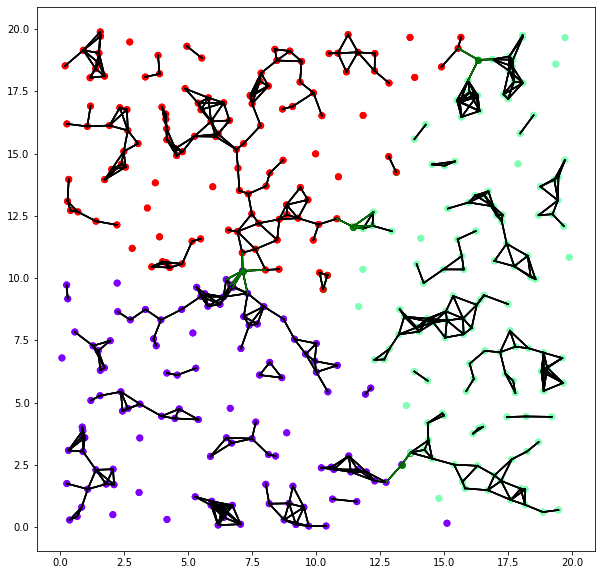

In [15]:
plot_points(ax, x, y, groups_, array_of_groups)
plot_firewalls(ax, array_of_groups, protect='self')

# plot_points_plotly(x, y, groups_, array_of_groups)
# # plot_firewalls_plotly(fig, array_of_groups, protect='self')


# # plot_borders(ax, xMax, xMin, yMax, yMin)
fig


### Multiway partitioning


In [9]:
i = 0
while i < num_of_clusters:
    startAgain = False
    for group in array_of_groups[i].connectedGroup:
        indicator = two_way_partitioning_enhanced(
            array_of_groups[i], array_of_groups[group], groups_)
        if indicator > 0:
            startAgain = True
            array_of_groups[i].find_connected_groups()
            array_of_groups[group].find_connected_groups()
    i = 0 if startAgain else i + 1


consider removing, no longer use edge matrix

In [10]:
edgeMatrixCopy = deepcopy(edge_matrix)


### One-way partitioning `our variation`

In [11]:
for group in array_of_groups:
    group.find_connected_groups()
# one point interchange
i = 0
while i < num_of_clusters:
    startAgain = False
    for group in array_of_groups[i].connectedGroup:
        indicator = one_way_partioning_enhanced(
            array_of_groups[i], array_of_groups[group], groups_, numbPoints/num_of_clusters, 0.1)
        if indicator > 0:
            startAgain = True
        array_of_groups[i].find_connected_groups()
        array_of_groups[group].find_connected_groups()
    i = 0 if startAgain else i + 1


##### Plot the graph 
`effects: multiway partitioning + oneway paritioning`

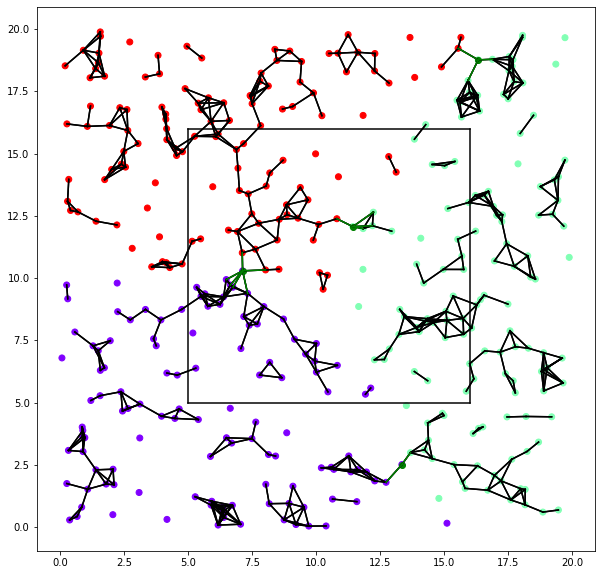

In [12]:
plot_points(ax2, x, y, groups_, array_of_groups)
plot_firewalls(ax2, array_of_groups, protect='self')
plot_borders(ax2, xMax, xMin, yMax, yMin)
fig2


### This is to debug the current problem of not detecting which side of the cluster should it consider 

[(16, 18), (13, 2), (11, 12)]
group_name: 0, #points, 119 dif_ori_cut: 10, connected_groups [1, 2]
group_name: 1, #points, 142 dif_ori_cut: -13, connected_groups [2, 0]
group_name: 2, #points, 127 dif_ori_cut: 2, connected_groups [1, 0]
388 141 116


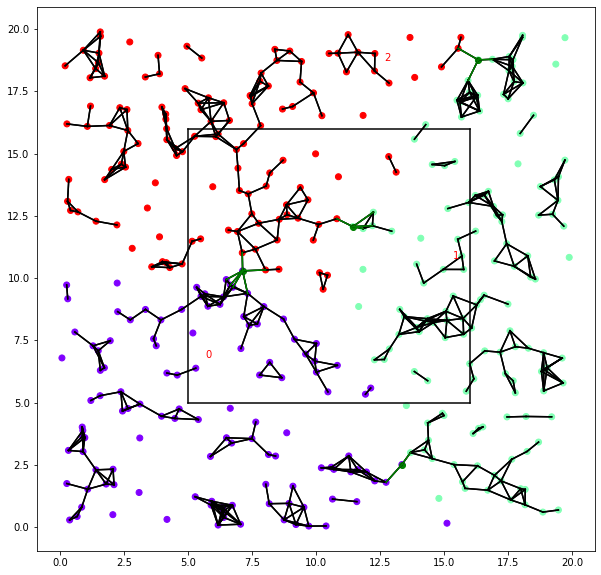

In [13]:
for group in array_of_groups:
    if group.name == 1:
        print(group.outerPoints)


for group in array_of_groups:
    x_ = group.points[floor(len(group.points)/2)].x
    y_ = group.points[floor(len(group.points)/2)].y
    print('group_name: {}, #points, {} dif_ori_cut: {}, connected_groups {}'.format(group.name, len(group.points), (int(numbPoints /
          num_of_clusters) - len(group.points)), (group.connectedGroup)))
    ax2.annotate(f'{group.name}', xy=(x_, y_), color='red',
                 xytext=(10, 10), textcoords="offset points")

print(numbPoints, int(int(numbPoints/num_of_clusters)*1.1),
      int((numbPoints/num_of_clusters)*0.9))

fig2


In [14]:
array_of_groups[0].points


[(6, 9),
 (4, 6),
 (12, 1),
 (6, 0),
 (3, 8),
 (0, 3),
 (0, 7),
 (8, 0),
 (4, 4),
 (7, 7),
 (9, 0),
 (11, 2),
 (5, 9),
 (0, 6),
 (12, 5),
 (15, 0),
 (5, 0),
 (1, 5),
 (7, 6),
 (3, 4),
 (1, 6),
 (0, 0),
 (0, 3),
 (3, 1),
 (4, 0),
 (7, 9),
 (1, 1),
 (7, 8),
 (6, 9),
 (9, 7),
 (1, 1),
 (11, 2),
 (0, 1),
 (10, 2),
 (10, 6),
 (0, 0),
 (11, 1),
 (6, 0),
 (9, 6),
 (0, 0),
 (6, 8),
 (10, 6),
 (0, 3),
 (0, 9),
 (1, 6),
 (6, 9),
 (4, 6),
 (5, 2),
 (5, 4),
 (5, 9),
 (7, 8),
 (0, 4),
 (7, 0),
 (3, 7),
 (5, 8),
 (8, 0),
 (2, 1),
 (8, 6),
 (4, 8),
 (5, 6),
 (0, 3),
 (11, 2),
 (3, 8),
 (6, 0),
 (2, 8),
 (10, 5),
 (6, 3),
 (2, 8),
 (6, 3),
 (3, 3),
 (3, 7),
 (9, 0),
 (13, 2),
 (6, 9),
 (0, 3),
 (8, 8),
 (8, 1),
 (2, 4),
 (12, 1),
 (5, 1),
 (11, 5),
 (10, 7),
 (2, 2),
 (7, 3),
 (2, 0),
 (3, 4),
 (8, 6),
 (7, 8),
 (8, 3),
 (11, 2),
 (1, 2),
 (5, 1),
 (8, 2),
 (8, 2),
 (10, 2),
 (2, 9),
 (10, 0),
 (2, 5),
 (9, 1),
 (10, 2),
 (1, 7),
 (9, 6),
 (1, 7),
 (1, 5),
 (1, 7),
 (4, 4),
 (6, 0),
 (0, 9),
 (8, 0),
